### Reinforcement Learning Project 
### Dyna with different Variations
#### 10 X 10 Maze Environment



In [1]:
import gym
import maze_env
import numpy as np
import matplotlib.pyplot as plt

##### Initializing the Maze Environment

In [2]:
env = maze_env.MazeEnvRandom10x10(enable_render=False)
NUM_ACTIONS = env.action_space.n  
print("Number of actions: ", NUM_ACTIONS)
STATE_BOUNDS = list(zip(env.observation_space.low, env.observation_space.high))
print("State Bounds:",STATE_BOUNDS)
print("Observation Space: ", env.observation_space)
print("Maze Size: ", env.maze_size)
print("Initial State: ", env.state)

MAZE_SIZE = tuple((env.observation_space.high + np.ones(env.observation_space.shape)).astype(int))
NUM_BUCKETS = MAZE_SIZE 
print("Number of buckets: ", NUM_BUCKETS)

Number of actions:  4
State Bounds: [(0, 9), (0, 9)]
Observation Space:  Box(0, 9, (2,), int64)
Maze Size:  (10, 10)
Initial State:  [0. 0.]
Number of buckets:  (10, 10)


Environment:
- The agent may only choose to go up, down, right, or left ("N", "S", "E", "W"). If the way is blocked, it will remain at the same the location.
- The observation space is the (x, y) coordinate of the agent. The top left cell is (0, 0).
- A reward of 1 is given when the agent reaches the goal. For every step in the maze, the agent recieves a reward of -0.1/(number of cells).
- The maze is reset when the agent reaches the goal.

## Baseline Dyna

Episode 0 finished after 1782 steps with total reward = -0.7809999999999147.
Episode 1 finished after 547 steps with total reward = 0.4539999999999996.
Episode 2 finished after 2400 steps with total reward = -1.3989999999998468.
Episode 3 finished after 415 steps with total reward = 0.5859999999999996.
Episode 4 finished after 266 steps with total reward = 0.7349999999999999.
Episode 5 finished after 156 steps with total reward = 0.8449999999999999.
Episode 6 finished after 244 steps with total reward = 0.7569999999999998.
Episode 7 finished after 227 steps with total reward = 0.7739999999999998.
Episode 8 finished after 269 steps with total reward = 0.7319999999999998.
Episode 9 finished after 130 steps with total reward = 0.8709999999999999.
Episode 10 finished after 147 steps with total reward = 0.8539999999999999.
Episode 11 finished after 143 steps with total reward = 0.8579999999999999.
Episode 12 finished after 148 steps with total reward = 0.8529999999999999.
Episode 13 finishe

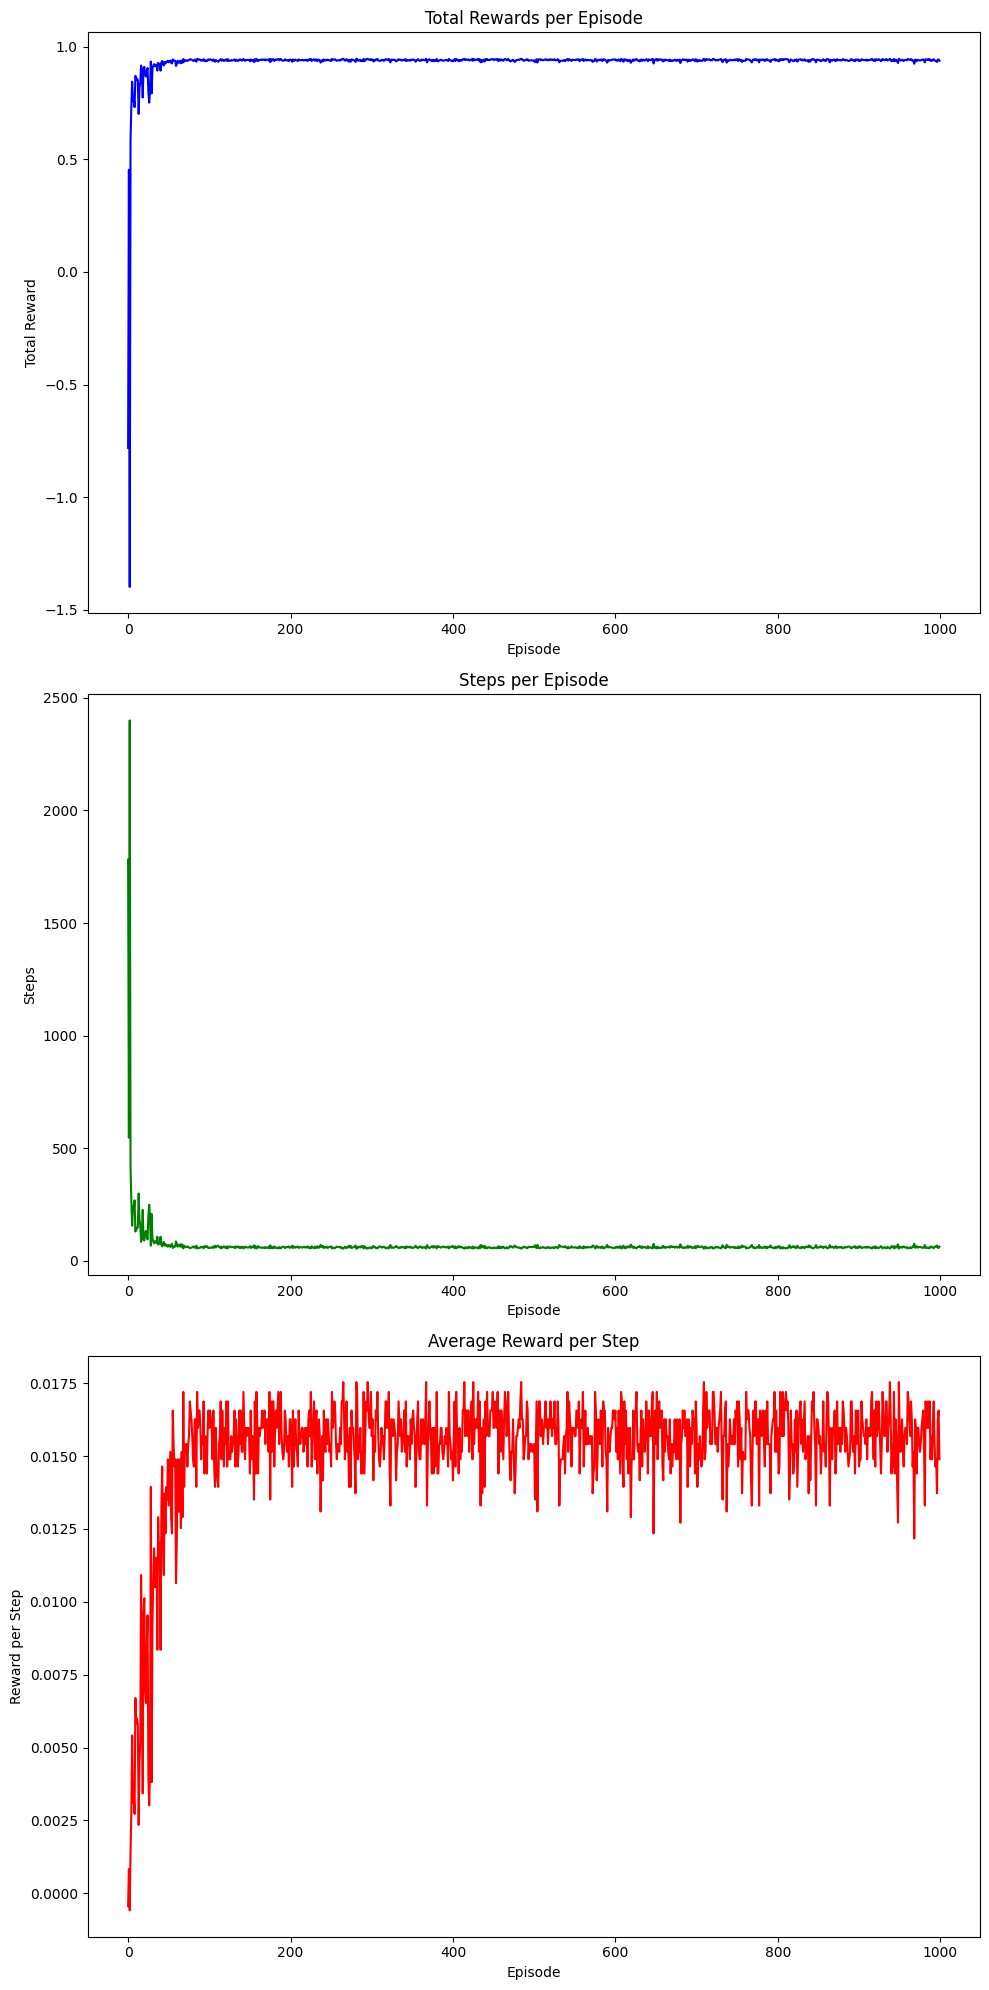

Overall success rate: 1.00


In [8]:
ACTION_MAPPING = {0: "N", 1: "E", 2: "S", 3: "W"}

class DynaQ_Agent:
    def __init__(self, action_space_size, state_space_shape, alpha=0.1, gamma=0.95, epsilon=0.1, planning_steps=10):
        self.q_table = np.zeros(state_space_shape + (action_space_size,))
        self.model = {}  # Simple model for simulating experiences
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.action_space_size = action_space_size
        self.planning_steps = planning_steps  # Number of planning steps per real step

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.action_space_size)
        return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state):
        # Direct learning from real experience
        predict = self.q_table[state + (action,)]
        target = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state + (action,)] += self.alpha * (target - predict)
        # Update the model
        self.model[(state, action)] = (reward, next_state)

    def planning(self):
        # Learning from simulated experience
        for _ in range(self.planning_steps):
            if len(self.model) == 0:
                return
            state, action = list(self.model.keys())[np.random.randint(len(self.model))]
            reward, next_state = self.model[(state, action)]
            self.learn(state, action, reward, next_state)

def run_episode(agent, env, num_episodes):
    total_rewards = []
    steps_per_episode = []
    successes = []

    for episode in range(num_episodes):
        state = env.reset()
        state = (int(state[0]), int(state[1]))
        total_reward = 0
        steps = 0
        success = False

        while True:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(ACTION_MAPPING[action])
            next_state = (int(next_state[0]), int(next_state[1]))

            agent.learn(state, action, reward, next_state)
            agent.planning()  
            
            state = next_state
            total_reward += reward
            steps += 1

            if done:
                success = (reward == 1)  
                successes.append(success)
                break
        
        total_rewards.append(total_reward)
        steps_per_episode.append(steps)
        print(f"Episode {episode} finished after {steps} steps with total reward = {total_reward}.")

    return total_rewards, steps_per_episode, successes

def simulate():
    env = maze_env.MazeEnvRandom10x10(enable_render=False)
    agent = DynaQ_Agent(env.action_space.n, (10, 10), alpha=0.1, gamma=0.95, epsilon=0.1, planning_steps=10)
    
    num_episodes = 1000 
    total_rewards, steps_per_episode, successes = run_episode(agent, env, num_episodes)
    success_rate = np.mean(successes)
    average_reward_per_step = [r / s if s > 0 else 0 for r, s in zip(total_rewards, steps_per_episode)]

    plt.figure(figsize=(10, 20))  
    plt.subplot(3, 1, 1)
    plt.plot(total_rewards, color='blue')
    plt.title('Total Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')

    plt.subplot(3, 1, 2)
    plt.plot(steps_per_episode, color='green')
    plt.title('Steps per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Steps')

    plt.subplot(3, 1, 3)
    plt.plot(average_reward_per_step, color='red')
    plt.title('Average Reward per Step')
    plt.xlabel('Episode')
    plt.ylabel('Reward per Step')

    plt.tight_layout()
    plt.show()
    print(f"Overall success rate: {success_rate:.2f}")

if __name__ == "__main__":
    simulate()

-	**Total Rewards per Episode:** The rewards quickly plateau after a short learning period, suggesting that the agent rapidly synthesizes its experiences to establish a successful strategy.
-	**Steps per Episode:** A steep decline in steps is noted initially, indicating fast learning. The plateau at a low level of steps signifies the agent's proficiency in consistently finding efficient routes to the goal.
-	**Average Reward per Step:** After an initial increase, the average reward per step stabilizes, albeit with some variation, reflecting the agent’s relatively consistent performance across episodes


## Variation 1 - Planning Phase Exploration Changes

Episode 0: Total Reward = -0.9759999999998932, Steps = 1977
Episode 1: Total Reward = -0.34899999999996223, Steps = 1350
Episode 2: Total Reward = 0.7369999999999999, Steps = 264
Episode 3: Total Reward = 0.7249999999999999, Steps = 276
Episode 4: Total Reward = 0.8549999999999999, Steps = 146
Episode 5: Total Reward = 0.8429999999999999, Steps = 158
Episode 6: Total Reward = 0.8909999999999999, Steps = 110
Episode 7: Total Reward = 0.8669999999999999, Steps = 134
Episode 8: Total Reward = 0.8859999999999999, Steps = 115
Episode 9: Total Reward = 0.9109999999999999, Steps = 90
Episode 10: Total Reward = 0.6089999999999998, Steps = 392
Episode 11: Total Reward = 0.9119999999999999, Steps = 89
Episode 12: Total Reward = 0.8519999999999999, Steps = 149
Episode 13: Total Reward = 0.952, Steps = 49
Episode 14: Total Reward = 0.7939999999999998, Steps = 207
Episode 15: Total Reward = 0.9139999999999999, Steps = 87
Episode 16: Total Reward = 0.9149999999999999, Steps = 86
Episode 17: Total Re

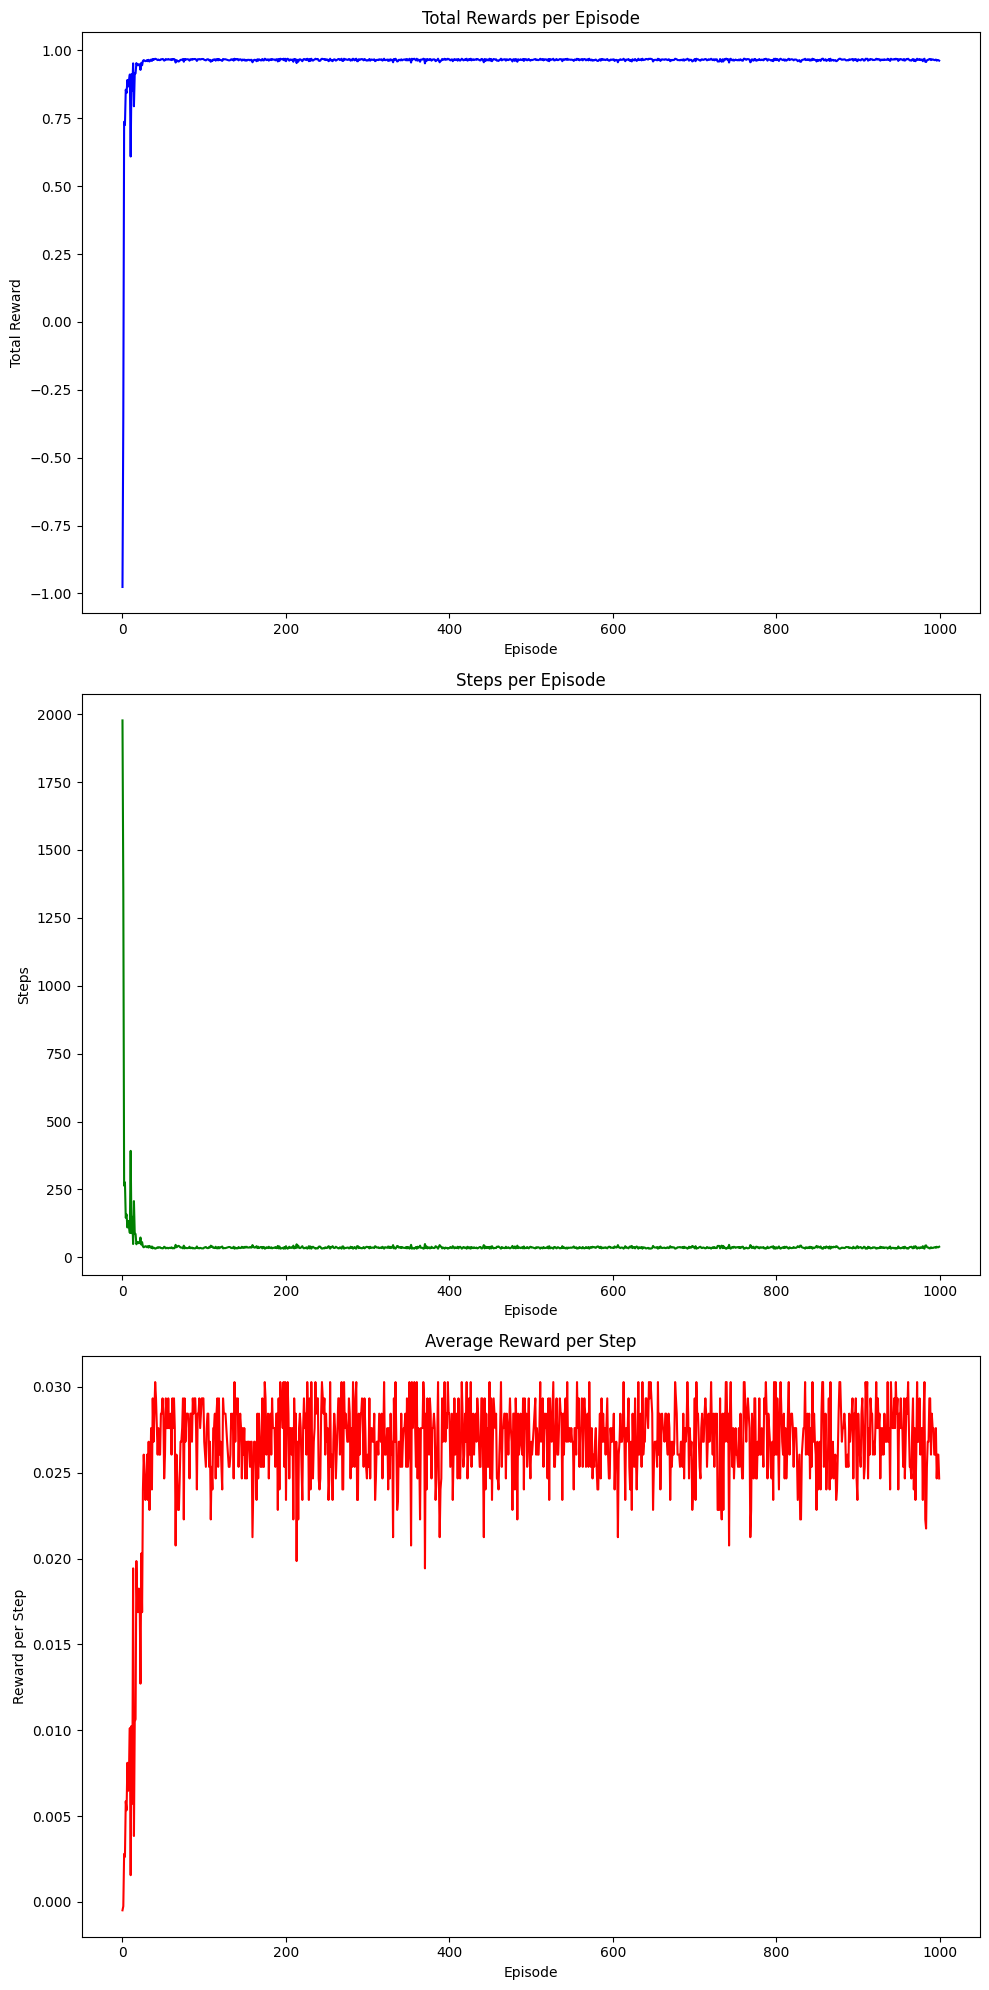

In [10]:
ACTION_MAPPING = {0: "N", 1: "E", 2: "S", 3: "W"}

class DynaQ_Agent_ExplorationInPlanning:
    def __init__(self, action_space_size, state_space_shape, alpha=0.1, gamma=0.99, epsilon=0.1, planning_steps=10, epsilon_planning=0.1):
        self.q_table = np.zeros(state_space_shape + (action_space_size,))
        self.model = {}  # Simple model for simulating experiences
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon  # Exploration rate in the real environment
        self.epsilon_planning = epsilon_planning  # Exploration rate in planning
        self.action_space_size = action_space_size
        self.planning_steps = planning_steps

    def choose_action(self, state, epsilon):
        if np.random.rand() < epsilon:
            return np.random.randint(0, self.action_space_size)
        return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state):
        predict = self.q_table[state + (action,)]
        target = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state + (action,)] += self.alpha * (target - predict)
        self.model[(state, action)] = (reward, next_state)

    def planning(self):
        for _ in range(self.planning_steps):
            if len(self.model) == 0:
                return
            state, action = list(self.model.keys())[np.random.randint(len(self.model))]
            reward, next_state = self.model[(state, action)]
            self.learn(state, action, reward, next_state)

def simulate(env, num_episodes=1000):
    agent = DynaQ_Agent_ExplorationInPlanning(env.action_space.n, (10, 10), alpha=0.1, gamma=0.99, epsilon=0.1, planning_steps=10, epsilon_planning=0.2)
    total_rewards = []
    steps_per_episode = []

    for episode in range(num_episodes):
        state = env.reset()
        state = (int(state[0]), int(state[1]))
        total_reward = 0
        steps = 0

        while True:
            action = agent.choose_action(state, agent.epsilon)
            next_state, reward, done, _ = env.step(ACTION_MAPPING[action])
            next_state = (int(next_state[0]), int(next_state[1]))

            agent.learn(state, action, reward, next_state)
            agent.planning()

            state = next_state
            total_reward += reward
            steps += 1

            if done:
                print(f"Episode {episode}: Total Reward = {total_reward}, Steps = {steps}")
                break

        total_rewards.append(total_reward)
        steps_per_episode.append(steps)

    # Plotting the results
    plt.figure(figsize=(10, 20))
    plt.subplot(3, 1, 1)
    plt.plot(total_rewards, color='blue')
    plt.title('Total Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')

    plt.subplot(3, 1, 2)
    plt.plot(steps_per_episode, color='green')
    plt.title('Steps per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Steps')

    average_rewards_per_step = [r / s if s > 0 else 0 for r, s in zip(total_rewards, steps_per_episode)]
    plt.subplot(3, 1, 3)
    plt.plot(average_rewards_per_step, color='red')
    plt.title('Average Reward per Step')
    plt.xlabel('Episode')
    plt.ylabel('Reward per Step')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    env = maze_env.MazeEnvRandom10x10(enable_render=False)  
    simulate(env)

-	**Total Rewards per Episode:** The rewards quickly reach a plateau, indicating the agent rapidly identifies a rewarding policy within the maze and consistently applies it.
-	**Steps per Episode:** The number of steps dramatically decreases in the initial episodes and flattens out, suggesting that the agent finds and refines a near-optimal path to the goal early in the learning process.
-	**Average Reward per Step:** The average reward per step ascends initially and then oscillates around a stable mean, which might indicate that the agent has found a balance between exploring new possibilities and exploiting its current knowledge base.


## Variation 2 - Discount Factor Changes

Running simulation with gamma = 0.8
Episode 0 finished after 3869 steps with total reward = -2.867999999999685.
Episode 1 finished after 915 steps with total reward = 0.0859999999999993.
Episode 2 finished after 1357 steps with total reward = -0.35599999999996146.
Episode 3 finished after 103 steps with total reward = 0.8979999999999999.
Episode 4 finished after 127 steps with total reward = 0.8739999999999999.
Episode 5 finished after 83 steps with total reward = 0.9179999999999999.
Episode 6 finished after 63 steps with total reward = 0.938.
Episode 7 finished after 45 steps with total reward = 0.956.
Episode 8 finished after 93 steps with total reward = 0.9079999999999999.
Episode 9 finished after 67 steps with total reward = 0.9339999999999999.
Episode 10 finished after 62 steps with total reward = 0.939.
Episode 11 finished after 75 steps with total reward = 0.9259999999999999.
Episode 12 finished after 122 steps with total reward = 0.8789999999999999.
Episode 13 finished after 11

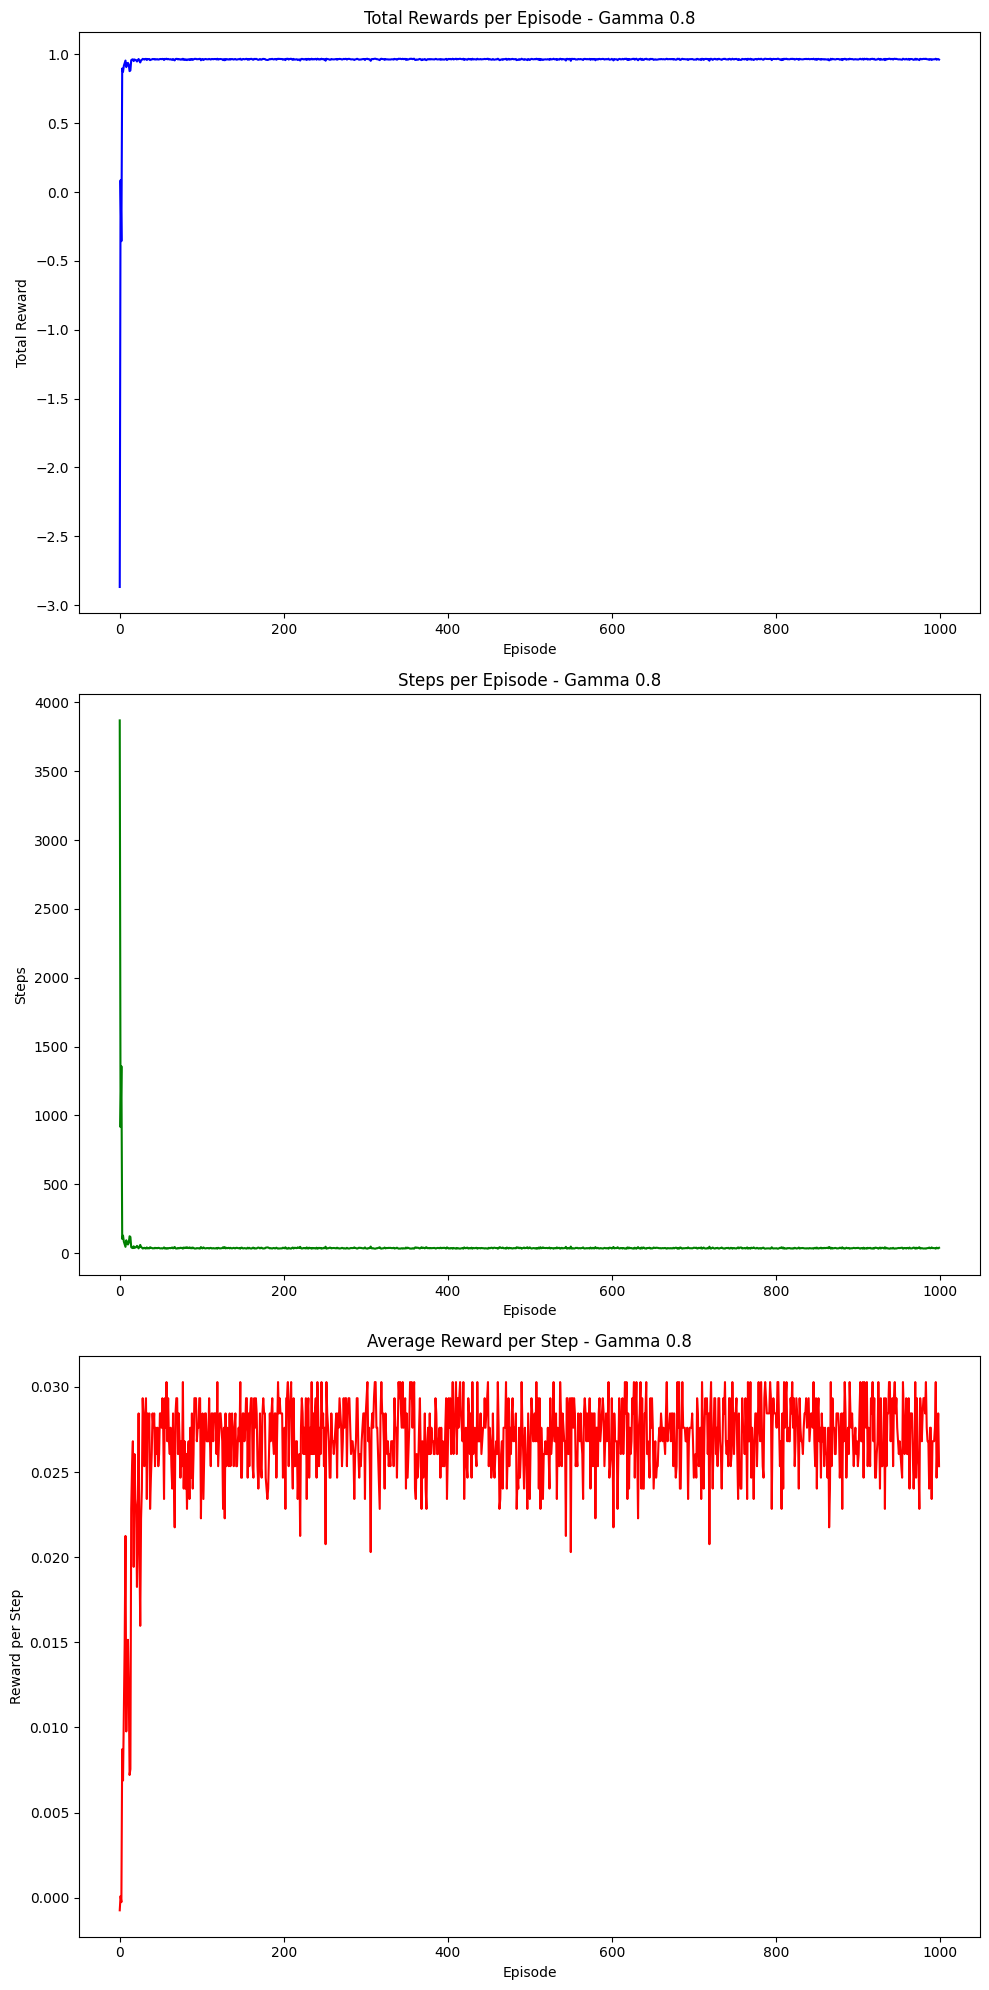

Running simulation with gamma = 0.9
Episode 0 finished after 5116 steps with total reward = -4.115000000000043.
Episode 1 finished after 1476 steps with total reward = -0.47499999999994835.
Episode 2 finished after 178 steps with total reward = 0.8229999999999998.
Episode 3 finished after 102 steps with total reward = 0.8989999999999999.
Episode 4 finished after 111 steps with total reward = 0.8899999999999999.
Episode 5 finished after 67 steps with total reward = 0.9339999999999999.
Episode 6 finished after 294 steps with total reward = 0.7069999999999999.
Episode 7 finished after 87 steps with total reward = 0.9139999999999999.
Episode 8 finished after 228 steps with total reward = 0.7729999999999998.
Episode 9 finished after 356 steps with total reward = 0.6449999999999998.
Episode 10 finished after 298 steps with total reward = 0.7029999999999998.
Episode 11 finished after 201 steps with total reward = 0.7999999999999998.
Episode 12 finished after 44 steps with total reward = 0.957

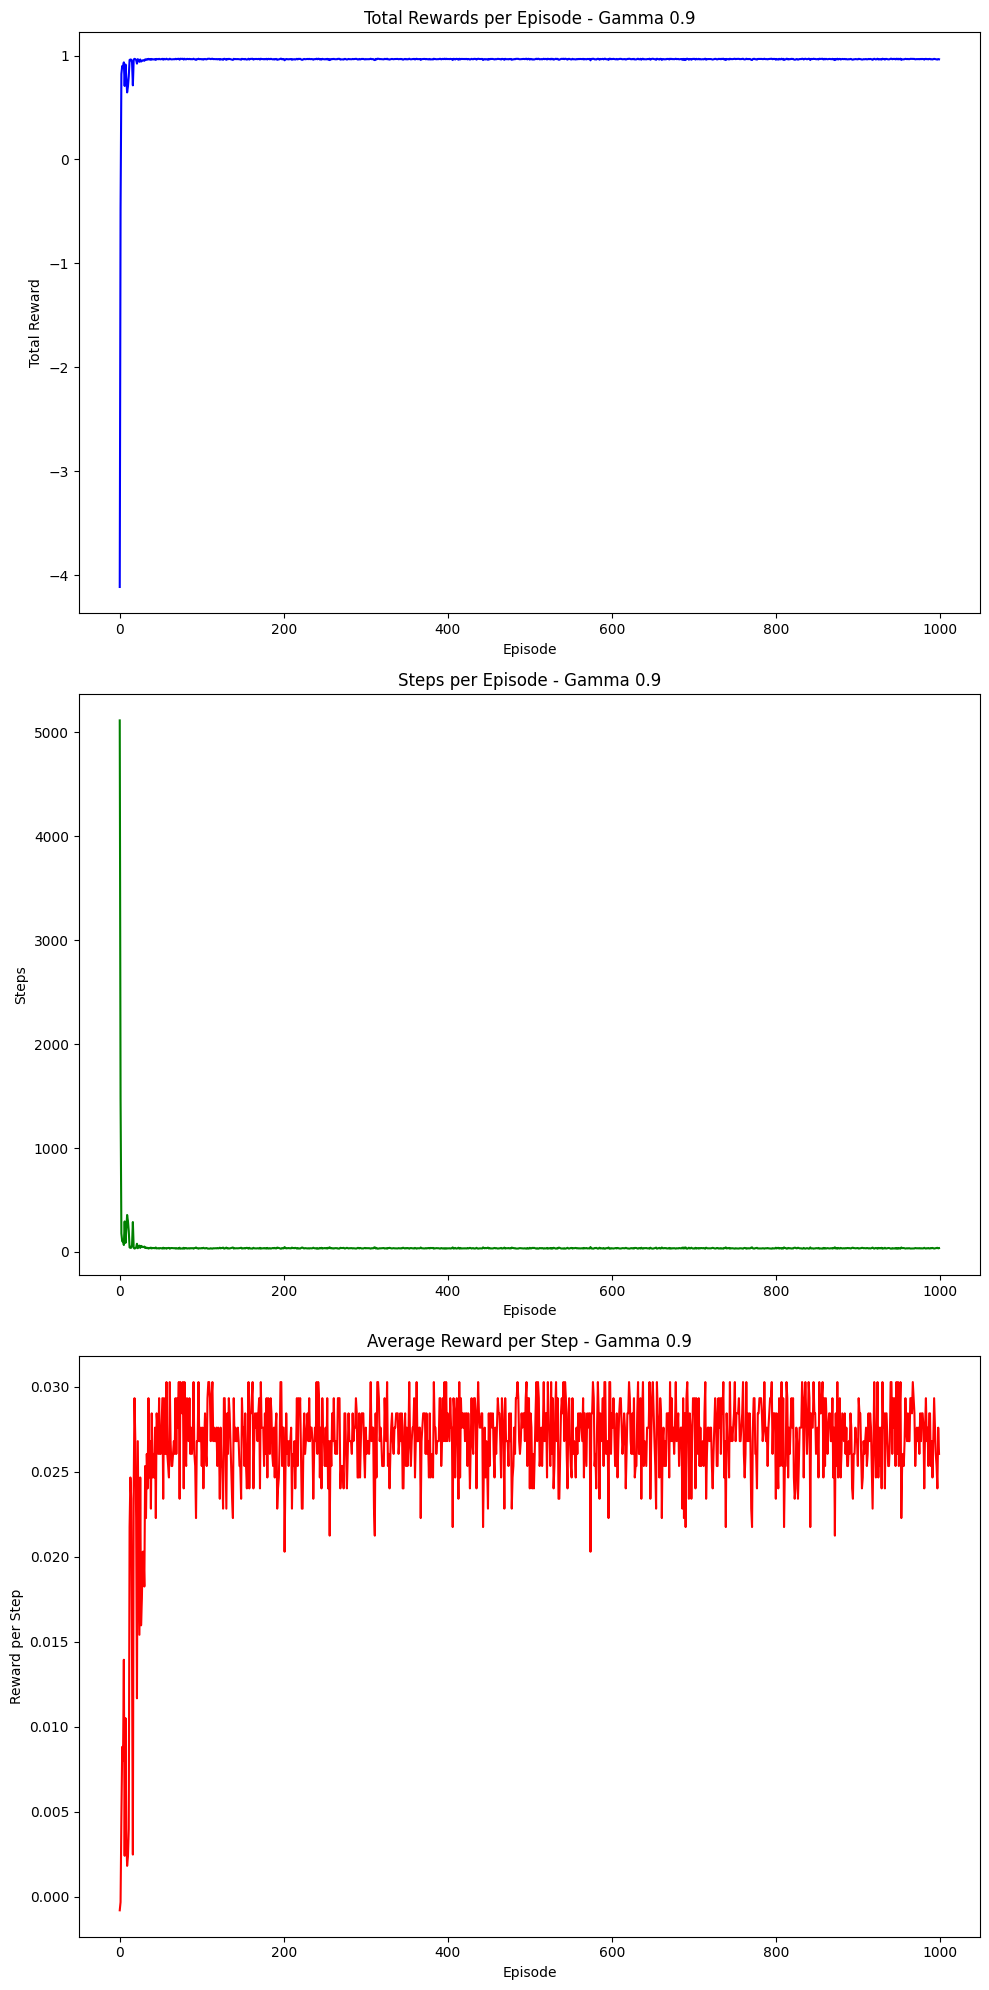

Running simulation with gamma = 0.95
Episode 0 finished after 2149 steps with total reward = -1.1479999999998745.
Episode 1 finished after 2011 steps with total reward = -1.0099999999998897.
Episode 2 finished after 679 steps with total reward = 0.3219999999999995.
Episode 3 finished after 441 steps with total reward = 0.5599999999999996.
Episode 4 finished after 162 steps with total reward = 0.8389999999999999.
Episode 5 finished after 381 steps with total reward = 0.6199999999999997.
Episode 6 finished after 227 steps with total reward = 0.7739999999999998.
Episode 7 finished after 161 steps with total reward = 0.8399999999999999.
Episode 8 finished after 264 steps with total reward = 0.7369999999999999.
Episode 9 finished after 68 steps with total reward = 0.9329999999999999.
Episode 10 finished after 90 steps with total reward = 0.9109999999999999.
Episode 11 finished after 51 steps with total reward = 0.95.
Episode 12 finished after 57 steps with total reward = 0.944.
Episode 13 f

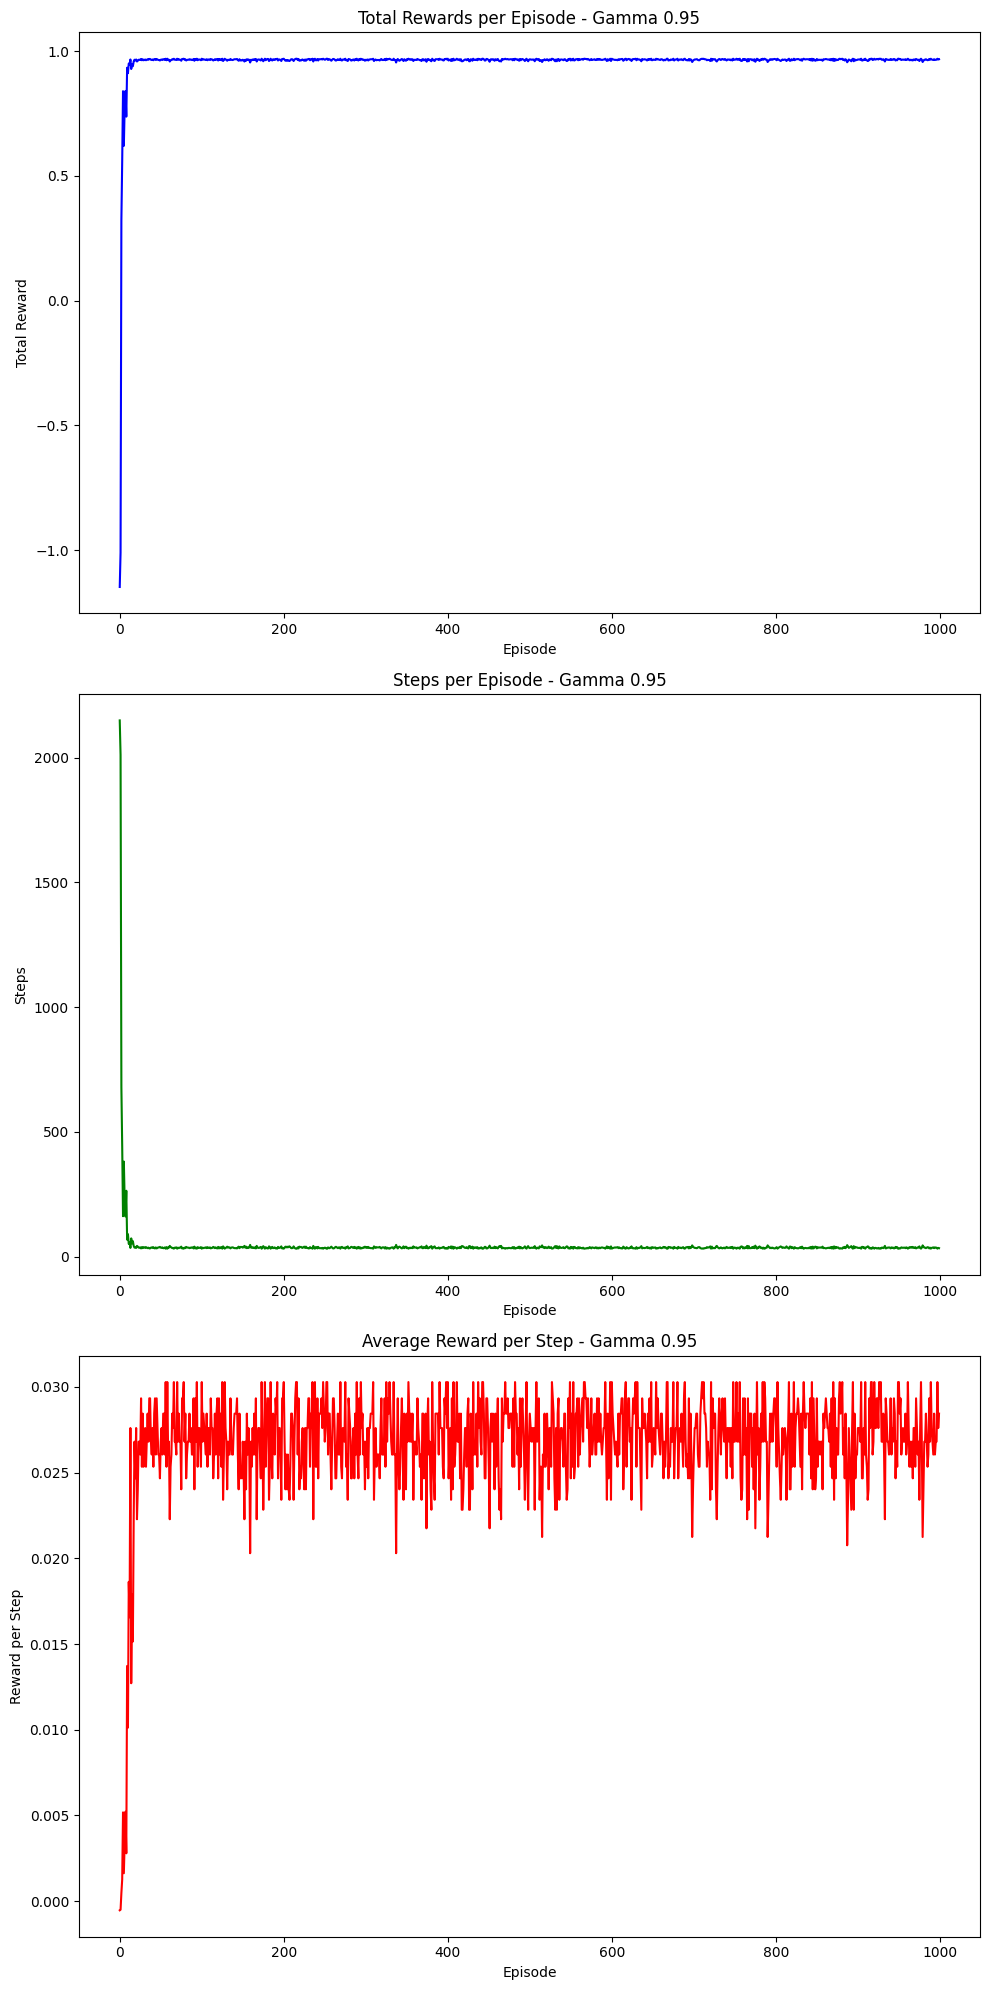

Running simulation with gamma = 0.99
Episode 0 finished after 5940 steps with total reward = -4.939000000000318.
Episode 1 finished after 272 steps with total reward = 0.7289999999999999.
Episode 2 finished after 154 steps with total reward = 0.8469999999999999.
Episode 3 finished after 510 steps with total reward = 0.49099999999999966.
Episode 4 finished after 397 steps with total reward = 0.6039999999999996.
Episode 5 finished after 437 steps with total reward = 0.5639999999999996.
Episode 6 finished after 571 steps with total reward = 0.4299999999999996.
Episode 7 finished after 47 steps with total reward = 0.954.
Episode 8 finished after 55 steps with total reward = 0.946.
Episode 9 finished after 58 steps with total reward = 0.943.
Episode 10 finished after 332 steps with total reward = 0.6689999999999998.
Episode 11 finished after 59 steps with total reward = 0.942.
Episode 12 finished after 96 steps with total reward = 0.9049999999999999.
Episode 13 finished after 128 steps with

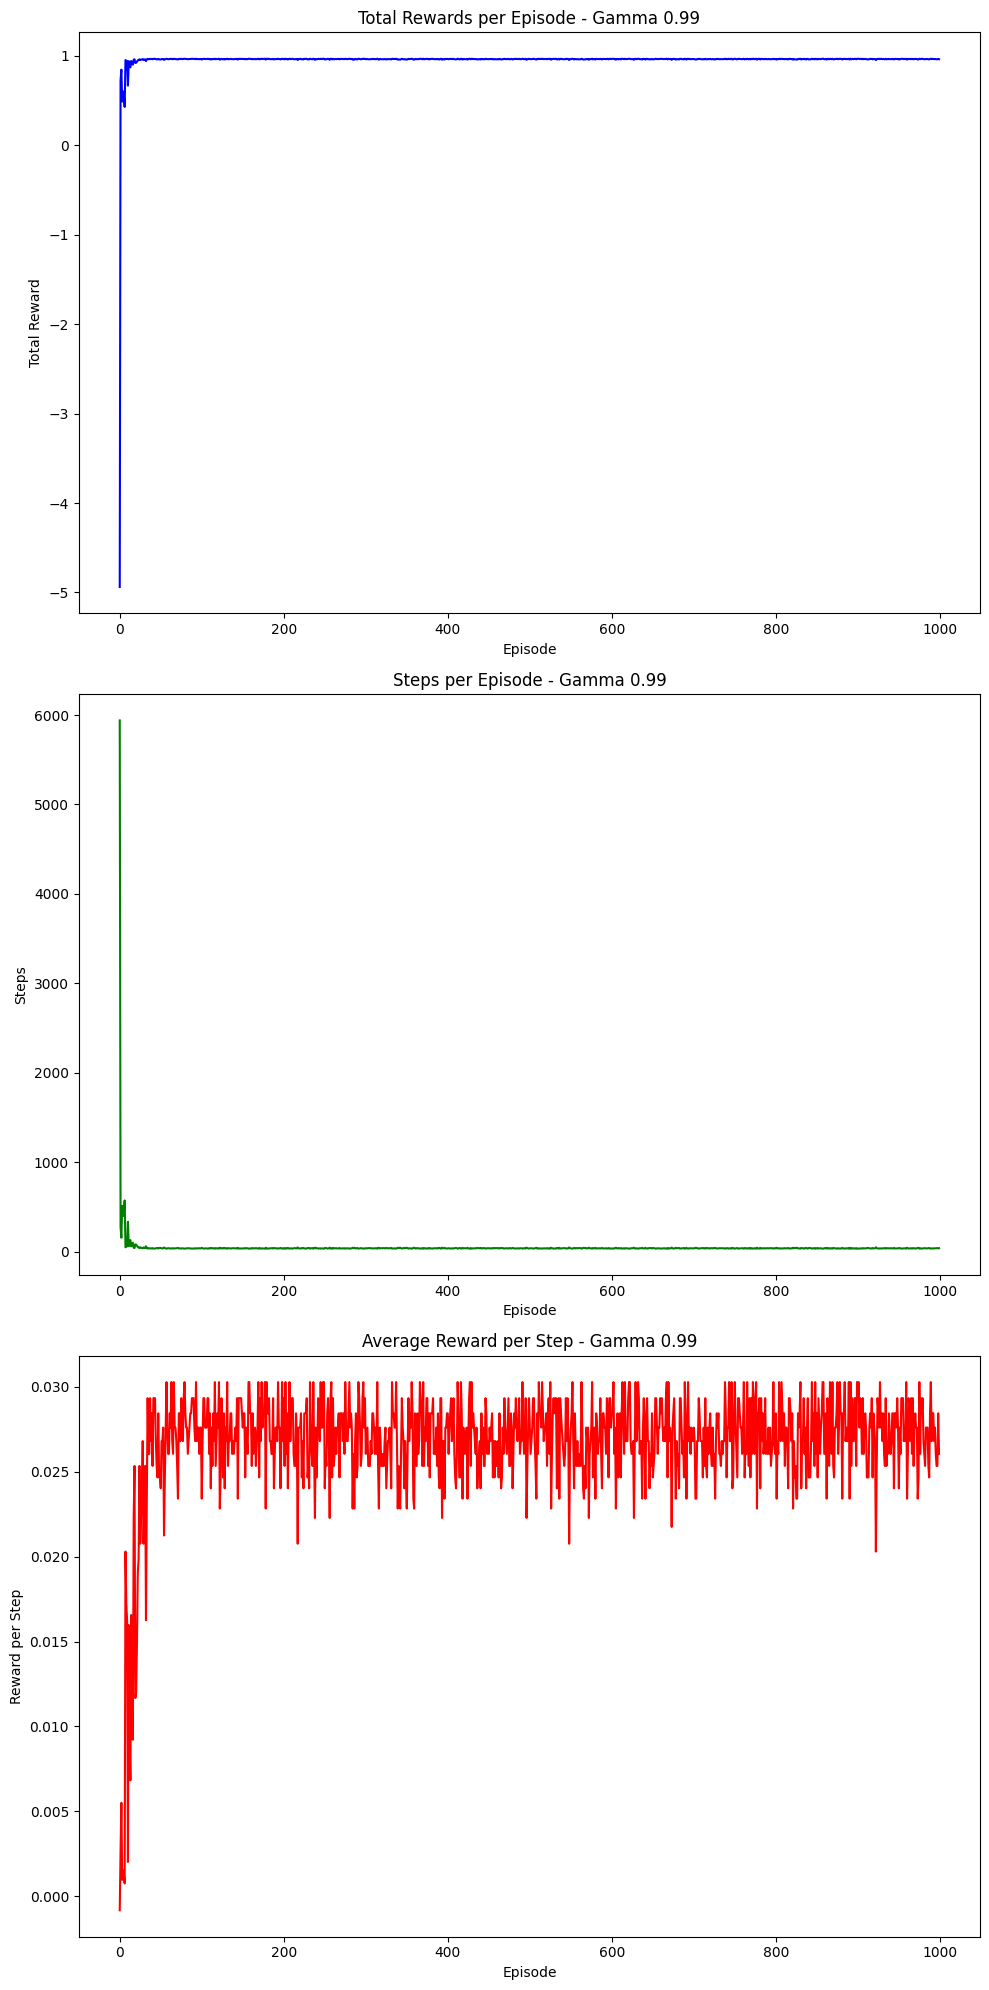

In [12]:
ACTION_MAPPING = {0: "N", 1: "E", 2: "S", 3: "W"}

class DynaQ_Agent:
    def __init__(self, action_space_size, state_space_shape, alpha=0.1, gamma=0.95, epsilon=0.1, planning_steps=10):
        self.q_table = np.zeros(state_space_shape + (action_space_size,))
        self.model = {}  # Simple model for simulating experiences
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.action_space_size = action_space_size
        self.planning_steps = planning_steps

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.action_space_size)
        return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state):
        predict = self.q_table[state + (action,)]
        target = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state + (action,)] += self.alpha * (target - predict)
        self.model[(state, action)] = (reward, next_state)

    def planning(self):
        for _ in range(self.planning_steps):
            if len(self.model) == 0:
                return
            state, action = list(self.model.keys())[np.random.randint(len(self.model))]
            reward, next_state = self.model[(state, action)]
            self.learn(state, action, reward, next_state)

def run_episode(agent, env, num_episodes):
    total_rewards = []
    steps_per_episode = []

    for episode in range(num_episodes):
        state = env.reset()
        state = (int(state[0]), int(state[1]))
        total_reward = 0
        steps = 0

        while True:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(ACTION_MAPPING[action])
            next_state = (int(next_state[0]), int(next_state[1]))

            agent.learn(state, action, reward, next_state)
            agent.planning()
            
            state = next_state
            total_reward += reward
            steps += 1

            if done:
                break

        total_rewards.append(total_reward)
        steps_per_episode.append(steps)
        print(f"Episode {episode} finished after {steps} steps with total reward = {total_reward}.")

    return total_rewards, steps_per_episode

def simulate(env, gamma_values):
    num_episodes = 1000
    for gamma in gamma_values:
        print(f"Running simulation with gamma = {gamma}")
        agent = DynaQ_Agent(env.action_space.n, (10, 10), alpha=0.1, gamma=gamma, epsilon=0.1, planning_steps=10)
        total_rewards, steps_per_episode = run_episode(agent, env, num_episodes)

        average_reward_per_step = [r / s if s > 0 else 0 for r, s in zip(total_rewards, steps_per_episode)]

        plt.figure(figsize=(10, 20))
        plt.subplot(3, 1, 1)
        plt.plot(total_rewards, label=f'Gamma = {gamma}', color='blue')
        plt.title(f'Total Rewards per Episode - Gamma {gamma}')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')

        plt.subplot(3, 1, 2)
        plt.plot(steps_per_episode, label=f'Gamma = {gamma}', color='green')
        plt.title(f'Steps per Episode - Gamma {gamma}')
        plt.xlabel('Episode')
        plt.ylabel('Steps')

        plt.subplot(3, 1, 3)
        plt.plot(average_reward_per_step, label=f'Gamma = {gamma}', color='red')
        plt.title(f'Average Reward per Step - Gamma {gamma}')
        plt.xlabel('Episode')
        plt.ylabel('Reward per Step')

        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    gamma_values = [0.8, 0.9, 0.95, 0.99]
    simulate(env, gamma_values)


-	**Total Rewards per Episode:** The plateau in the total rewards graph indicates the agent has quickly found a consistent strategy that garners a stable amount of rewards in navigating the maze.
-	**Steps per Episode:** The number of steps taken per episode sharply decreases and levels off, showing the agent is learning to find the goal more efficiently.
-	**Average Reward per Step:** The average reward per step demonstrates an early rapid increase, followed by stability with minor fluctuations, suggesting the agent is making more advantageous moves as it gains experience.


## Variation 3 - Learning Rate Changes

Running simulation with learning rate (alpha) = 0.1


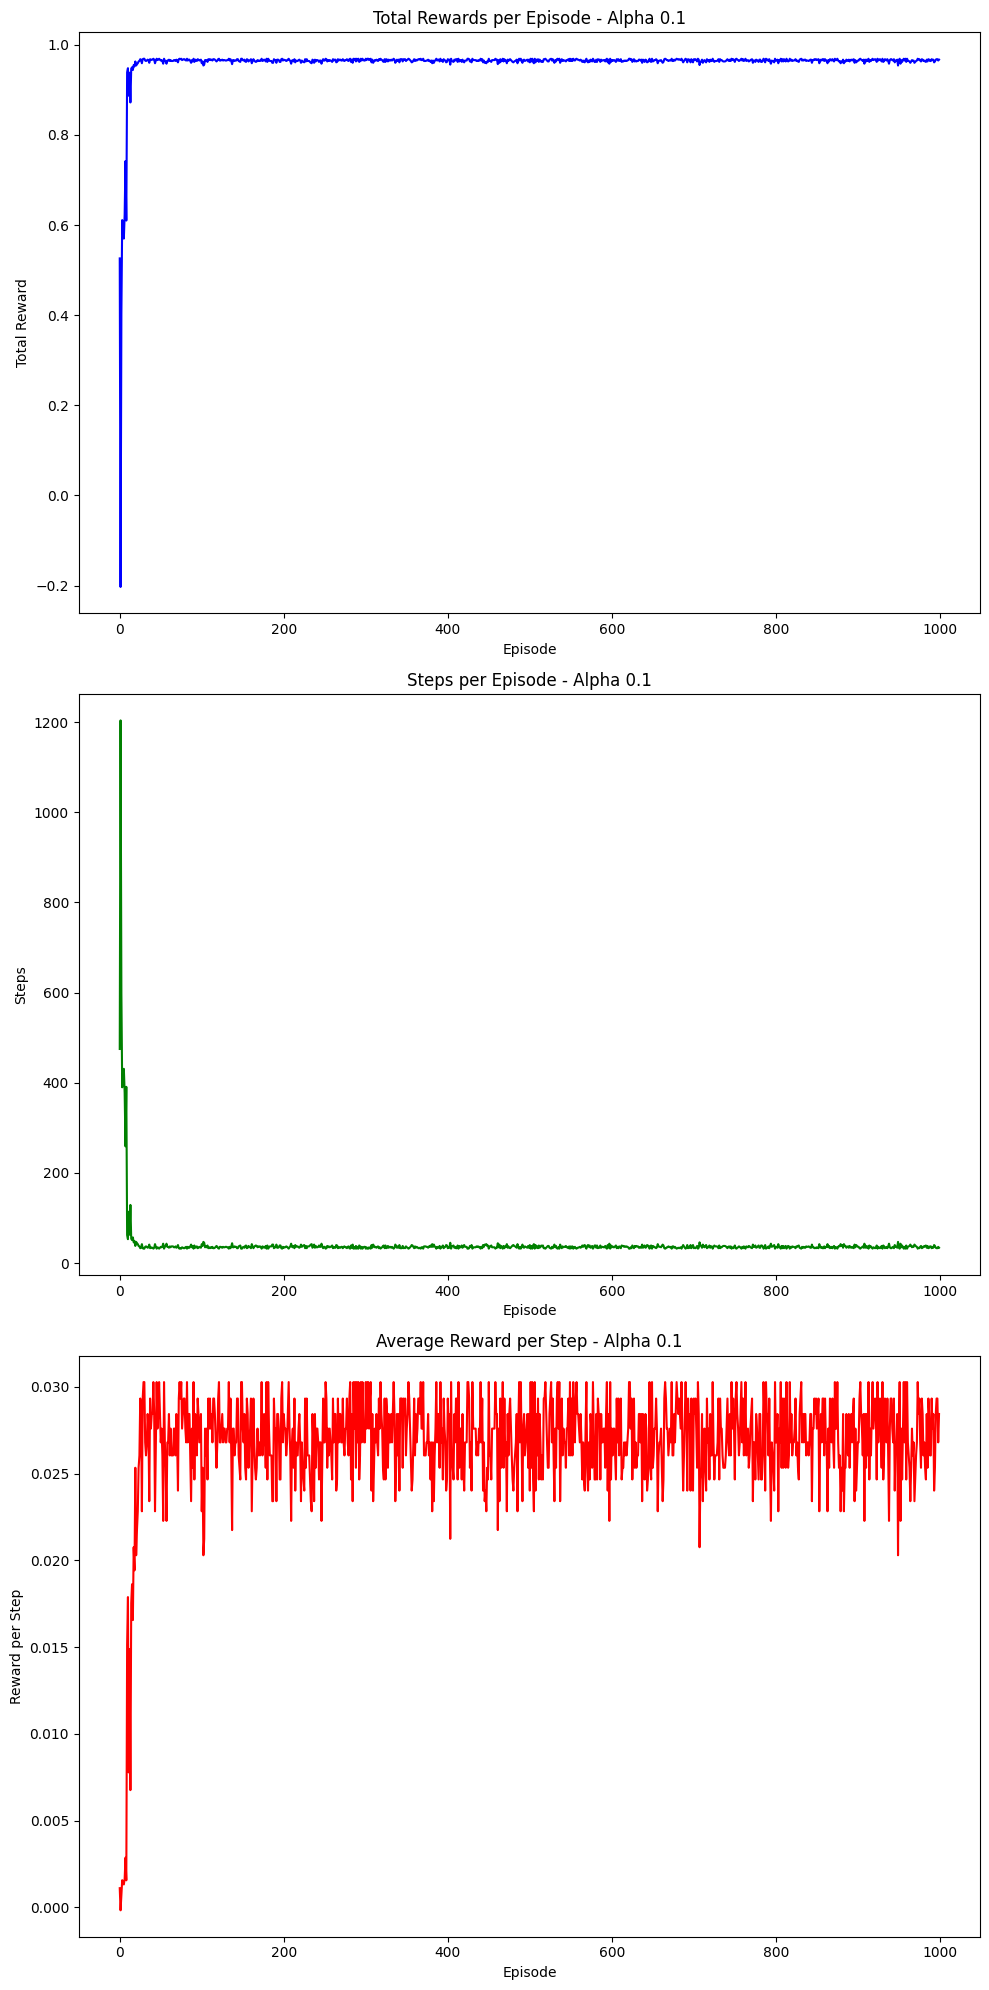

Running simulation with learning rate (alpha) = 0.9


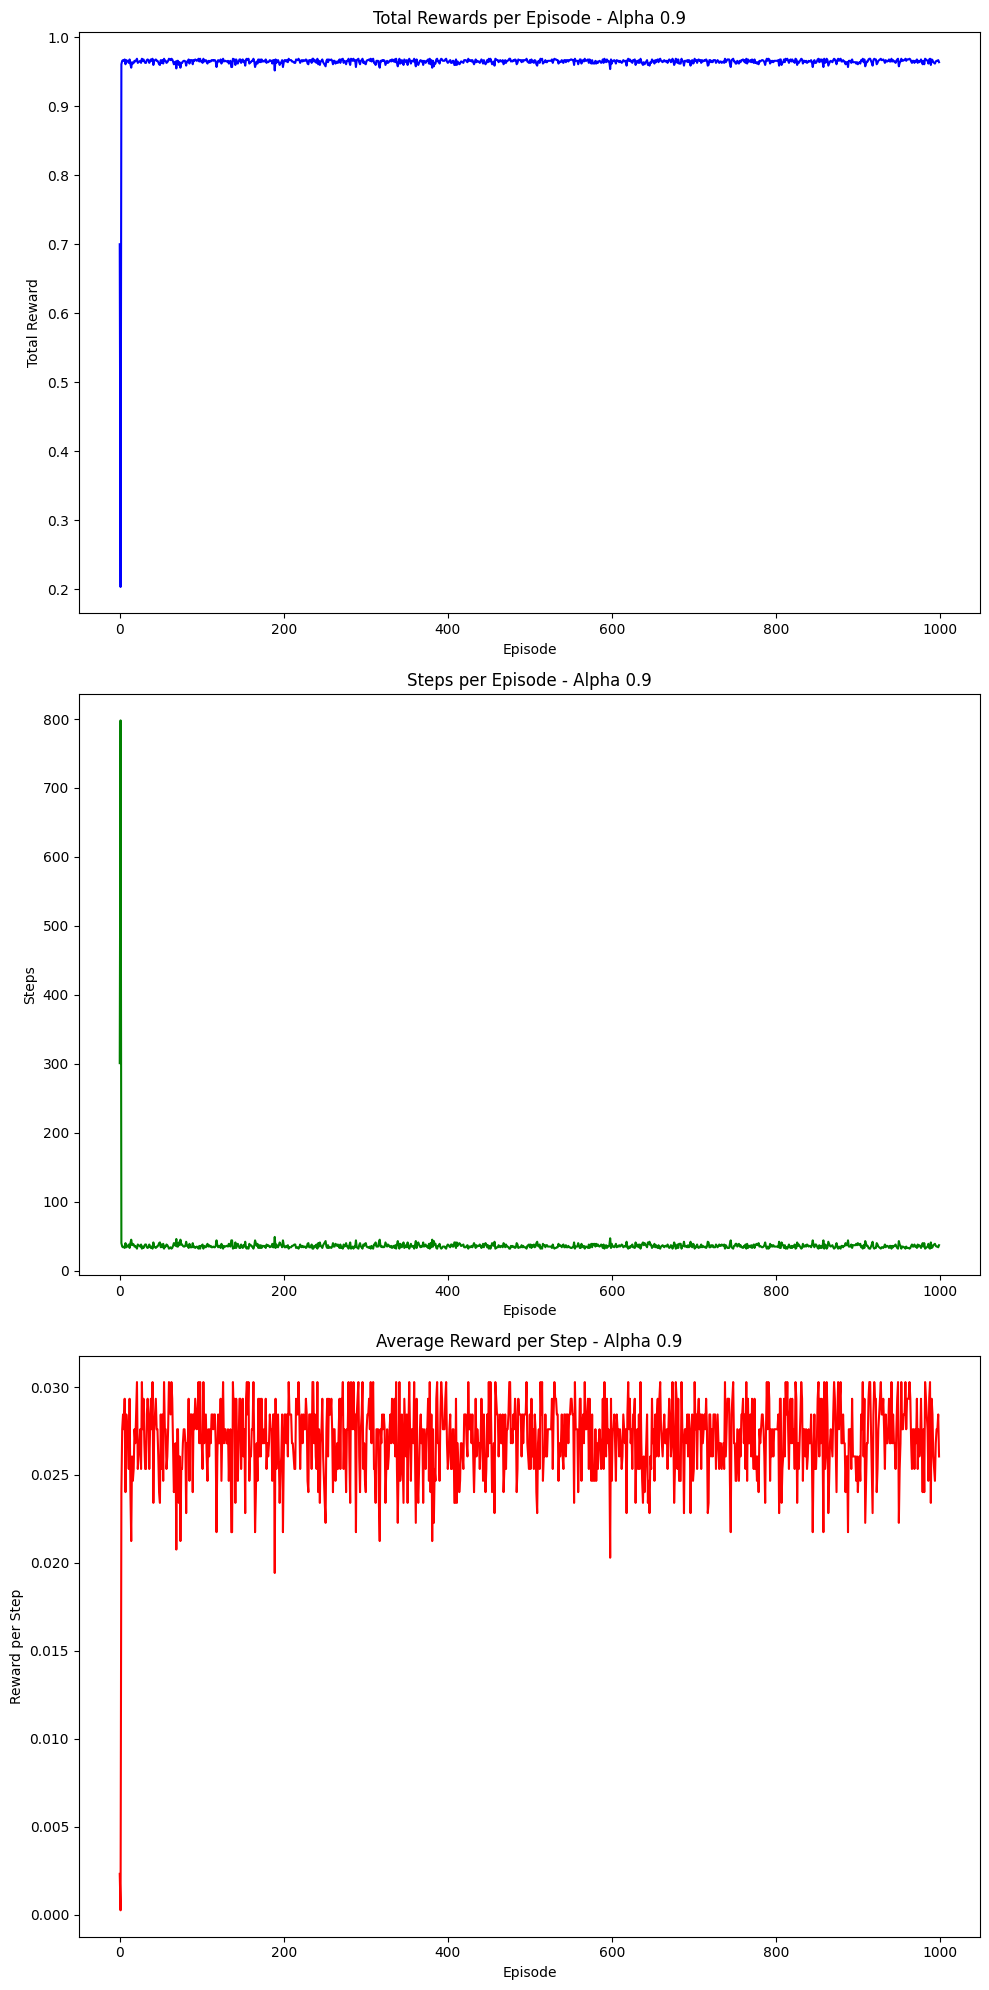

In [15]:
ACTION_MAPPING = {0: "N", 1: "E", 2: "S", 3: "W"}

class DynaQ_Agent:
    def __init__(self, action_space_size, state_space_shape, alpha=0.1, gamma=0.95, epsilon=0.1, planning_steps=10):
        self.q_table = np.zeros(state_space_shape + (action_space_size,))
        self.model = {}  # Simple model for simulating experiences
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.action_space_size = action_space_size
        self.planning_steps = planning_steps

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, self.action_space_size)
        return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state):
        predict = self.q_table[state + (action,)]
        target = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state + (action,)] += self.alpha * (target - predict)
        self.model[(state, action)] = (reward, next_state)

    def planning(self):
        for _ in range(self.planning_steps):
            if len(self.model) == 0:
                return
            state, action = list(self.model.keys())[np.random.randint(len(self.model))]
            reward, next_state = self.model[(state, action)]
            self.learn(state, action, reward, next_state)

def run_episode(agent, env, num_episodes):
    total_rewards = []
    steps_per_episode = []

    for episode in range(num_episodes):
        state = env.reset()
        state = (int(state[0]), int(state[1]))
        total_reward = 0
        steps = 0

        while True:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(ACTION_MAPPING[action])
            next_state = (int(next_state[0]), int(next_state[1]))

            agent.learn(state, action, reward, next_state)
            agent.planning()
            
            state = next_state
            total_reward += reward
            steps += 1

            if done:
                total_rewards.append(total_reward)
                steps_per_episode.append(steps)
                break

    average_reward_per_step = [r / s if s > 0 else 0 for r, s in zip(total_rewards, steps_per_episode)]
    return total_rewards, steps_per_episode, average_reward_per_step

def simulate_with_different_alphas(env, alpha_values):
    num_episodes = 1000
    for alpha in alpha_values:
        print(f"Running simulation with learning rate (alpha) = {alpha}")
        agent = DynaQ_Agent(env.action_space.n, (10, 10), alpha=alpha, gamma=0.95, epsilon=0.1, planning_steps=10)
        total_rewards, steps_per_episode, average_reward_per_step = run_episode(agent, env, num_episodes)

        plt.figure(figsize=(10, 20))
        plt.subplot(3, 1, 1)
        plt.plot(total_rewards, color='blue')
        plt.title(f'Total Rewards per Episode - Alpha {alpha}')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')

        plt.subplot(3, 1, 2)
        plt.plot(steps_per_episode, color='green')
        plt.title(f'Steps per Episode - Alpha {alpha}')
        plt.xlabel('Episode')
        plt.ylabel('Steps')

        plt.subplot(3, 1, 3)
        plt.plot(average_reward_per_step, color='red')
        plt.title(f'Average Reward per Step - Alpha {alpha}')
        plt.xlabel('Episode')
        plt.ylabel('Reward per Step')

        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    alpha_values = [0.1, 0.9]
    simulate_with_different_alphas(env, alpha_values)

-	**Total Rewards per Episode:** The total rewards stabilize quickly, which suggests that the agent is efficiently learning a strategy to navigate the maze for optimal rewards.
-	**Steps per Episode:** The graph shows a swift decline in the number of steps, indicating the agent learns to reach the goal more directly in early episodes, with little further improvement, which may signal an early convergence to a good policy.
-	**Average Reward per Step:** The rewards per step rise sharply and then reach a plateau with some minor noise. This pattern signifies that the agent has found a way to maximize its reward on a per-step basis after the initial learning period.
